In [ ]:
# Import required libraries
import requests
import dask.dataframe as dd
import glob
import os
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession


import pyspark.sql.functions as F
from functools import reduce
import sqlite3
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder, StandardScaler
from pyspark.ml import Pipeline
import requests
import matplotlib.ticker as ticker

# useful functions


In [ ]:
def clear_screen(): #clear the screen
    clear_output(wait=True) 

def load_and_tag(table_prefix, years):#load the data from the database and tag the year
    merged_df = None
    for year in years:
        table = f"{table_prefix}_{year}"
        df = spark.read \
            .format("jdbc") \
            .option("url", "jdbc:sqlite:/data/nyc_taxi.db") \
            .option("dbtable", table) \
            .option("driver", "org.sqlite.JDBC") \
            .load() \
            .withColumn("year", F.lit(year))
        
        merged_df = df if merged_df is None else merged_df.unionByName(df)
    
    return merged_df
years_function = [2020, 2021, 2022, 2023, 2024]

# Downloading and converting

In [ ]:
#download the sqlite-jdbc-3.41.2.1.jar file
url = "https://repo1.maven.org/maven2/org/xerial/sqlite-jdbc/3.41.2.1/sqlite-jdbc-3.41.2.1.jar"
filename = "sqlite-jdbc-3.41.2.1.jar"

print(f"Downloading {filename}...")
response = requests.get(url)
if response.status_code == 200:
    with open(filename, "wb") as f:
        f.write(response.content)
    print(f"Successfully downloaded {filename}")
else:
    print(f"Failed to download {filename} (status {response.status_code})")

In [ ]:
#download the data from the website
years = [2020,2021,2022, 2023, 2024]
months = [1,2,3,4,5,6,7,8,9,10,11,12]
taxis = ["yellow", "green"]

for year in years:
  for month in months:
    for taxi in taxis:
      if month < 10:
        url = f"https://d37ci6vzurychx.cloudfront.net/trip-data/{taxi}_tripdata_{year}-0{month}.parquet"
        filename = f"{taxi}_tripdata_{year}-{month}.parquet"
        print(f"Downloading {filename} ...")
        r = requests.get(url)
        if r.status_code == 200:
          with open(filename, "wb") as f:
            f.write(r.content)
        else:
          print(f"Failed to download {filename} (status {r.status_code})")
      else:
        url = f"https://d37ci6vzurychx.cloudfront.net/trip-data/{taxi}_tripdata_{year}-{month}.parquet"
        filename = f"{taxi}_tripdata_{year}-{month}.parquet"
        print(f"Downloading {filename} ...")
        r = requests.get(url)
        if r.status_code == 200:
          with open(filename, "wb") as f:
            f.write(r.content)
        else:
          print(f"Failed to download {filename} (status {r.status_code})")

In [ ]:
# convert the parquet files to csv files
directory=('C:\\Users\\hansi\\Documents\\cont\\')
files = glob.glob(os.path.join(directory, '*.parquet'))

for file in files:
    print(f'processing {file}')
    data = dd.read_parquet(file)
    base, _ = os.path.splitext(file)
    csv_file = base + '.csv'
    data.to_csv(csv_file, single_file=True, index=False)
    print(f'{file} finished')

processing C:\Users\hansi\Documents\cont\green_tripdata_2020-1.parquet
C:\Users\hansi\Documents\cont\green_tripdata_2020-1.parquet finished
processing C:\Users\hansi\Documents\cont\green_tripdata_2020-10.parquet
C:\Users\hansi\Documents\cont\green_tripdata_2020-10.parquet finished
processing C:\Users\hansi\Documents\cont\green_tripdata_2020-11.parquet
C:\Users\hansi\Documents\cont\green_tripdata_2020-11.parquet finished
processing C:\Users\hansi\Documents\cont\green_tripdata_2020-12.parquet
C:\Users\hansi\Documents\cont\green_tripdata_2020-12.parquet finished
processing C:\Users\hansi\Documents\cont\green_tripdata_2020-2.parquet
C:\Users\hansi\Documents\cont\green_tripdata_2020-2.parquet finished
processing C:\Users\hansi\Documents\cont\green_tripdata_2020-3.parquet
C:\Users\hansi\Documents\cont\green_tripdata_2020-3.parquet finished
processing C:\Users\hansi\Documents\cont\green_tripdata_2020-4.parquet
C:\Users\hansi\Documents\cont\green_tripdata_2020-4.parquet finished
processing C:\

# Pyspark

In [ ]:
directory = "/data/" # set the working directory

In [ ]:
jdbc_jar = "/data/sqlite-jdbc-3.41.2.1.jar" #path to the jdbc jar file

In [ ]:
#spark session
spark = SparkSession.builder \
    .appName("datacol_exam_optimized") \
    .config("spark.driver.extraClassPath", jdbc_jar) \
    .config("spark.executor.extraClassPath", jdbc_jar) \
    .config("spark.driver.memory", "80g") \
    .config("spark.executor.memory", "120g") \
    .config("spark.sql.shuffle.partitions", "136") \
    .config("spark.driver.maxResultSize", "40g") \
    .config("spark.driver.cores", "2") \
    .config("spark.executor.cores", "8") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.dynamicAllocation.minExecutors", "3") \
    .config("spark.dynamicAllocation.maxExecutors", "4") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.adaptive.skewJoin.enabled", "true") \
    .config("spark.sql.adaptive.localShuffleReader.enabled", "true") \
    .config("spark.sql.adaptive.advisoryPartitionSizeInBytes", "200m") \
    .config("spark.sql.adaptive.forceApply", "true") \
    .config("spark.ml.numPartitions", "136") \
    .config("spark.sql.adaptive.skewJoin.skewedPartitionThresholdInBytes", "200m") \
    .config("spark.sql.adaptive.skewJoin.skewedPartitionFactor", "4") \
    .config("spark.sql.adaptive.autoBroadcastJoinThreshold", "100m") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.sql.adaptive.maxShuffledHashJoinLocalMapThreshold", "0") \
    .getOrCreate()#custom spark session to optimize the performance, utilising the resources of the machine to the fullest

In [ ]:
#sorting the files by taxi type
greentaxis = glob.glob(os.path.join(directory, 'green*.csv')) 
yellowtaxis = glob.glob(os.path.join(directory, 'yellow*.csv'))

In [ ]:
#loading the green taxi data
green_taxi_dfs = {}
file_counter=0
for file in greentaxis:
  file_counter += 1
  print(f"on file {file_counter}")
  clear_screen()
  csvname = os.path.splitext(os.path.basename(file))[0]
  green_taxi_dfs[csvname] = spark.read.csv(file, header=True, inferSchema=True)

on file 60


In [ ]:
#loading the yellow taxi data
yellow_taxi_dfs = {}
file_counter=0
for file in yellowtaxis:
  file_counter += 1
  print(f"on file {file_counter}")
  clear_screen()
  csvname = os.path.splitext(os.path.basename(file))[0]
  yellow_taxi_dfs[csvname] = spark.read.csv(file, header=True, inferSchema=True)

on file 60


# 2. Clean data: remove nulls, invalid distances/fares, and standardize datetime formats

In [ ]:
green_taxi_dfs['green_tripdata_2020-1'].printSchema() #print the schema of the green taxi data

root
 |-- VendorID: integer (nullable = true)
 |-- lpep_pickup_datetime: timestamp (nullable = true)
 |-- lpep_dropoff_datetime: timestamp (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- ehail_fee: string (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: double (nullable = true)
 |-- trip_type: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)



In [ ]:
yellow_taxi_dfs['yellow_tripdata_2020-1'].printSchema() #print the schema of the yellow taxi data

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: string (nullable = true)



### green


In [ ]:
#check the number of rows in the green taxi data
green_total_rows = 0
for i in green_taxi_dfs:
  print(f"{i}")
  print(green_taxi_dfs[i].count())
  green_total_rows += green_taxi_dfs[i].count()
  
print(f"total rows in green: {green_total_rows}")

green_tripdata_2020-1
447770
green_tripdata_2020-10
95120
green_tripdata_2020-11
88605
green_tripdata_2020-12
83130
green_tripdata_2020-2
398632
green_tripdata_2020-3
223496
green_tripdata_2020-4
35644
green_tripdata_2020-5
57361
green_tripdata_2020-6
63110
green_tripdata_2020-7
72258
green_tripdata_2020-8
81063
green_tripdata_2020-9
87987
green_tripdata_2021-1
76518
green_tripdata_2021-10
110891
green_tripdata_2021-11
108229
green_tripdata_2021-12
99961
green_tripdata_2021-2
64572
green_tripdata_2021-3
83827
green_tripdata_2021-4
86941
green_tripdata_2021-5
88180
green_tripdata_2021-6
86737
green_tripdata_2021-7
83691
green_tripdata_2021-8
83499
green_tripdata_2021-9
95709
green_tripdata_2022-1
62495
green_tripdata_2022-10
69322
green_tripdata_2022-11
62313
green_tripdata_2022-12
72439
green_tripdata_2022-2
69399
green_tripdata_2022-3
78537
green_tripdata_2022-4
76136
green_tripdata_2022-5
76891
green_tripdata_2022-6
73718
green_tripdata_2022-7
64192
green_tripdata_2022-8
65929
green_

In [ ]:
#check for null values in the green taxi data
for i in green_taxi_dfs:
  print(f"on {i}")
  null_counts = green_taxi_dfs[i].select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in green_taxi_dfs[i].columns])
  null_counts.show()

on green_tripdata_2020-1
+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+
|VendorID|lpep_pickup_datetime|lpep_dropoff_datetime|store_and_fwd_flag|RatecodeID|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|ehail_fee|improvement_surcharge|total_amount|payment_type|trip_type|congestion_surcharge|
+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+
|       0|                   0|                    0|            116051|    116051|           0|           0|         116051|            0

In [27]:
#droping ehail column as it contains no values

for i in green_taxi_dfs:
  green_taxi_dfs[i] = green_taxi_dfs[i].drop("ehail_fee")

In [ ]:
#drop the rows with null values
for i in green_taxi_dfs:
  green_taxi_dfs[i] = green_taxi_dfs[i].dropna()

In [ ]:
#checking the number of rows after dropping the null values
green_rows_after_drop=0
for i in green_taxi_dfs:
  green_rows_after_drop += green_taxi_dfs[i].count()
print(f"rows before drop: {green_total_rows}")
print(f"rows after drop: {green_rows_after_drop}")

rows before drop: 5090611
rows after drop: 3979533


checking for invalid values

In [ ]:
#counting the rows with negative distance and fare amount
negative_distance_count= 0
negative_fare_amount_count = 0
for i in green_taxi_dfs:
 negative_distance =  green_taxi_dfs[i].filter(F.col("trip_distance") <= 0).count()
 negative_fare_amount = green_taxi_dfs[i].filter(F.col("fare_amount") <= 0).count()
 negative_distance_count += negative_distance
 negative_fare_amount_count += negative_fare_amount


In [31]:
print(negative_distance_count)
print(negative_fare_amount_count)

212669
22914


In [ ]:
#filtering out the rows with negative distance, fare amount and passenger count
green_rows_after_drop=0
for i in green_taxi_dfs:
  green_taxi_dfs[i] = green_taxi_dfs[i].filter(F.col("trip_distance") > 0)
  green_taxi_dfs[i] = green_taxi_dfs[i].filter(F.col("fare_amount") > 0)
  green_taxi_dfs[i] = green_taxi_dfs[i].filter(F.col("passenger_count") > 0)
  green_rows_after_drop += green_taxi_dfs[i].count()
print(f"rows after drop: {green_rows_after_drop}")

rows after drop: 3733529


standardizing the dates

In [ ]:
#converting the datetime columns to timestamp
for i in green_taxi_dfs:
  green_taxi_dfs[i]=green_taxi_dfs[i].withColumn("lpep_pickup_datetime", F.to_timestamp("lpep_pickup_datetime"))
  green_taxi_dfs[i]=green_taxi_dfs[i].withColumn("lpep_dropoff_datetime", F.to_timestamp("lpep_dropoff_datetime"))

In [34]:
green_taxi_dfs['green_tripdata_2022-1'].printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- lpep_pickup_datetime: timestamp (nullable = true)
 |-- lpep_dropoff_datetime: timestamp (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: double (nullable = true)
 |-- trip_type: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)



### yellow

In [ ]:
#counting the number of rows in the yellow taxi data
yellow_total_rows = 0
for i in yellow_taxi_dfs:
  print(f"{i}")
  print(yellow_taxi_dfs[i].count())
  yellow_total_rows += yellow_taxi_dfs[i].count()
  #clear_screen()
print(f"total rows in yellow: {yellow_total_rows}")

yellow_tripdata_2020-1
6405008
yellow_tripdata_2020-10
1681132
yellow_tripdata_2020-11
1509000
yellow_tripdata_2020-12
1461898
yellow_tripdata_2020-2
6299367
yellow_tripdata_2020-3
3007687
yellow_tripdata_2020-4
238073
yellow_tripdata_2020-5
348415
yellow_tripdata_2020-6
549797
yellow_tripdata_2020-7
800412
yellow_tripdata_2020-8
1007286
yellow_tripdata_2020-9
1341017
yellow_tripdata_2021-1
1369769
yellow_tripdata_2021-10
3463504
yellow_tripdata_2021-11
3472949
yellow_tripdata_2021-12
3214369
yellow_tripdata_2021-2
1371709
yellow_tripdata_2021-3
1925152
yellow_tripdata_2021-4
2171187
yellow_tripdata_2021-5
2507109
yellow_tripdata_2021-6
2834264
yellow_tripdata_2021-7
2821746
yellow_tripdata_2021-8
2788757
yellow_tripdata_2021-9
2963793
yellow_tripdata_2022-1
2463931
yellow_tripdata_2022-10
3675411
yellow_tripdata_2022-11
3252717
yellow_tripdata_2022-12
3399549
yellow_tripdata_2022-2
2979431
yellow_tripdata_2022-3
3627882
yellow_tripdata_2022-4
3599920
yellow_tripdata_2022-5
3588295
yel

In [ ]:
#checking for null values in the yellow taxi data
for i in yellow_taxi_dfs:
  print(f"on {i}")
  null_counts = yellow_taxi_dfs[i].select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in yellow_taxi_dfs[i].columns])
  null_counts.show()

on yellow_tripdata_2020-1
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       0|                   0|                    0|          65441|            0|     65441|             65441|           0|           0|           0|         

In [ ]:
#removing the airport fee column from the yellow taxi data as it caused imense data loss because of the null values
for i in yellow_taxi_dfs:
  yellow_taxi_dfs[i] = yellow_taxi_dfs[i].drop("airport_fee")

In [ ]:
#dropping the rows with null values
for i in yellow_taxi_dfs:
  yellow_taxi_dfs[i] = yellow_taxi_dfs[i].dropna()

In [ ]:
#checking the number of rows in the yellow taxi data after dropping the null values
yellow_total_rows_after= 0
for i in yellow_taxi_dfs:
  print(f"{i}")
  print(yellow_taxi_dfs[i].count())
  yellow_total_rows_after += yellow_taxi_dfs[i].count()
  clear_screen()
print(yellow_total_rows_after)

165631891


Invalud trips and distances

In [ ]:
#counting the number of rows with negative distance and fare amount
negative_distance_count= 0
negative_fare_amount_count = 0
for i in yellow_taxi_dfs:
 negative_distance =  yellow_taxi_dfs[i].filter(F.col("trip_distance") <= 0).count()
 negative_fare_amount = yellow_taxi_dfs[i].filter(F.col("fare_amount") <= 0).count()
 negative_distance_count += negative_distance
 negative_fare_amount_count += negative_fare_amount
print(negative_distance_count)
print(negative_fare_amount_count)


2189741
1528499


In [ ]:
#filtering out the rows with negative distance, fare amount and passenger count
yellow_rows_after_drop=0
for i in yellow_taxi_dfs:
  yellow_taxi_dfs[i] = yellow_taxi_dfs[i].filter(F.col("trip_distance") > 0)
  yellow_taxi_dfs[i] = yellow_taxi_dfs[i].filter(F.col("fare_amount") > 0)
  yellow_taxi_dfs[i] = yellow_taxi_dfs[i].filter(F.col("passenger_count") > 0)
  yellow_rows_after_drop += yellow_taxi_dfs[i].count()
print(f"rows after drop: {yellow_rows_after_drop}")

rows after drop: 159258868


In [15]:
yellow_taxi_dfs['yellow_tripdata_2022-1'].printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)



## 3. Create consolidated DataFrames: yellow_all, green_all

### green

In [ ]:
#merging the green taxi data
green_all = reduce(lambda df1, df2: df1.unionByName(df2), green_taxi_dfs.values())

In [ ]:
#ordering the green taxi data by the pickup datetime
green_all = green_all.orderBy(F.col("lpep_pickup_datetime"))

In [21]:
green_all.count()

3733529

In [22]:
green_all.show()

+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------------------+------------+------------+---------+--------------------+
|VendorID|lpep_pickup_datetime|lpep_dropoff_datetime|store_and_fwd_flag|RatecodeID|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|payment_type|trip_type|congestion_surcharge|
+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------------------+------------+------------+---------+--------------------+
|       2| 2008-12-31 00:00:00|  2008-12-31 00:00:00|                 N|       1.0|          55|          55|            1.0|         6.29|       59.7|  0.0|    0.5|       0.0|         0.0|    

In [37]:

# keep only dates between 2022 and 2024
green_all = green_all.filter(
    (F.col("lpep_pickup_datetime") >= "2020-01-01") &
    (F.col("lpep_pickup_datetime") < "2025-01-01")
)
green_all.show()

+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------------------+------------+------------+---------+--------------------+
|VendorID|lpep_pickup_datetime|lpep_dropoff_datetime|store_and_fwd_flag|RatecodeID|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|payment_type|trip_type|congestion_surcharge|
+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------------------+------------+------------+---------+--------------------+
|       2| 2020-01-01 00:00:07|  2020-01-01 00:19:30|                 N|       1.0|         255|         237|            1.0|         5.07|       18.0|  0.5|    0.5|      4.41|         0.0|    

In [24]:
green_all.count()

3733453

### yellow

In [ ]:
#merging the yellow taxi data
yellow_all = reduce(lambda df1, df2: df1.unionByName(df2), yellow_taxi_dfs.values())

In [ ]:
#ordering the yellow taxi data by the pickup datetime
yellow_all = yellow_all.orderBy(F.col("tpep_pickup_datetime"))

In [18]:
yellow_all.count()

159258868

In [19]:
yellow_all.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|       2| 2001-01-01 00:03:14|  2001-01-01 01:12:47|            1.0|        20.77|       2.0|                 N|         132|         230|           2|       52.0|  0.0|    0.5|       0.0|        6.55|                  0.3

In [ ]:
#filtering the yellow taxi data to only include the years 2020-2024
yellow_all = yellow_all.filter(
    (F.col("tpep_pickup_datetime") >= "2020-01-01") &
    (F.col("tpep_pickup_datetime") < "2025-01-01")
)

In [21]:
yellow_all.count()

159257832

# To sql

In [ ]:
# initializing the database connection
database = '/data/nyc_taxi.db'
conn = sqlite3.connect(database)
cursor = conn.cursor()


In [ ]:
#adding the year column to the green taxi data
green_all = green_all.withColumn("year", F.year("lpep_pickup_datetime"))

In [ ]:
#adding the year column to the yellow taxi data
yellow_all = yellow_all.withColumn("year", F.year("tpep_pickup_datetime"))

In [39]:
years = green_all.select("year").distinct().rdd.flatMap(lambda x: x).collect()

In [ ]:
for y in years:
    # Filter the DataFrame for the given year and collapse partitions to one for consistent insertion.
    df_year = green_all.filter(F.col("year") == y).coalesce(1)

    # Define the target SQLite table name,  "green_2021" for year 2021.
    table_name = f"green_{y}"

    # Write directly to SQLite using JDBC.
    df_year.write \
        .format("jdbc") \
        .option("url", "jdbc:sqlite:/data/nyc_taxi.db") \
        .option("dbtable", table_name) \
        .option("driver", "org.sqlite.JDBC") \
        .mode("overwrite") \
        .save()

    print(f"Exported data for year {y} to table '{table_name}'")
    clear_screen()

Exported data for year 2024 to table 'green_2024'


In [42]:
for y in years:
    # Filter the DataFrame for the given year and collapse partitions to one for consistent insertion.
    df_year = yellow_all.filter(F.col("year") == y).coalesce(1)


    table_name = f"yellow_{y}"

    # Write directly to SQLite using JDBC.
    df_year.write \
        .format("jdbc") \
        .option("url", "jdbc:sqlite:/data/nyc_taxi.db") \
        .option("dbtable", table_name) \
        .option("driver", "org.sqlite.JDBC") \
        .mode("overwrite") \
        .save()

    print(f"Exported data for year {y} to table '{table_name}'")

Exported data for year 2020 to table 'yellow_2020'
Exported data for year 2021 to table 'yellow_2021'
Exported data for year 2022 to table 'yellow_2022'
Exported data for year 2023 to table 'yellow_2023'
Exported data for year 2024 to table 'yellow_2024'


In [8]:
# List all tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()


In [9]:
for name in tables:
    print(name)

('green_2020',)
('green_2021',)
('green_2022',)
('green_2023',)
('green_2024',)
('yellow_2020',)
('yellow_2021',)
('yellow_2022',)
('yellow_2023',)
('yellow_2024',)


In [ ]:
#counting the number of rows in the database
y=[2020,2021,2022,2023,2024]
c=["green","yellow"]
for year in y :
    for taxi in c:
        cursor.execute(f"SELECT COUNT(*) FROM {taxi}_{year};")
        print(f"{taxi}_{year} rows:", cursor.fetchone()[0])




green_2020 rows: 1137538
green_2021 rows: 618066
green_2022 rows: 697333
green_2023 rows: 686479
green_2024 rows: 594037


In [ ]:
# preview the data in the database
cursor.execute("SELECT * FROM green_2020 LIMIT 5;")
for row in cursor.fetchall():
    print(row)


(2, 1577836807000, 1577837970000, 'N', 1.0, 255, 237, 1.0, 5.07, 18.0, 0.5, 0.5, 4.41, 0.0, 0.3, 26.46, 1.0, 1.0, 2.75, 2020)
(1, 1577836821000, 1577837419000, 'N', 1.0, 89, 39, 1.0, 2.3, 10.0, 0.5, 0.5, 0.0, 0.0, 0.3, 11.3, 2.0, 1.0, 0.0, 2020)
(2, 1577836844000, 1577837226000, 'N', 1.0, 129, 70, 1.0, 2.71, 9.5, 0.5, 0.5, 0.0, 0.0, 0.3, 10.8, 2.0, 1.0, 0.0, 2020)
(2, 1577836864000, 1577837089000, 'N', 1.0, 75, 74, 1.0, 1.35, 6.0, 0.5, 0.5, 1.46, 0.0, 0.3, 8.76, 1.0, 1.0, 0.0, 2020)
(1, 1577836871000, 1577837612000, 'N', 1.0, 74, 238, 1.0, 2.5, 11.0, 3.25, 0.5, 3.0, 0.0, 0.3, 18.05, 1.0, 1.0, 2.75, 2020)


# Exploratory Data Analysis with PySpark

## Clear cache

In [ ]:
#clear the cache of the dataframes
def clear_cache(df_name):
    
    spark.catalog.clearCache()

    # 2.clear individual DataFrames more carefully
    try:
        if df_name in globals() and hasattr(globals()[df_name], 'unpersist'):
            globals()[df_name].unpersist()
            print(f"Cleared {df_name} DataFrame")
    except Exception as e:
        print(f"Could not clear {df_name}: {e}")

    # 3. Force garbage collection
    import gc
    gc.collect()
    gc.collect()

    # 4. Check cache status again
    print("Checking DataFrame cache status after clearing:")
    print([name for name, obj in globals().items() if hasattr(obj, 'is_cached') and obj.is_cached])


In [ ]:
#show the cache status of the dataframes
def show_cache_status():
    cached_objects = []
    for name, obj in list(globals().items()):
        if hasattr(obj, 'is_cached') and obj.is_cached:
            cached_objects.append(f"{name}: {type(obj)} - CACHED")

    for item in cached_objects:
        print(f"  {item}")

## Loading

In [ ]:
# loading the green taxi data
green = load_and_tag("green", years_function)

In [8]:
green.count()

3733453

In [ ]:
#load the yellow taxi data
yellow = load_and_tag("yellow", years_function)

In [21]:
yellow.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+----+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|year|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+----+
|       1| 2020-01-01 00:00:00|  2020-01-01 00:13:03|            1.0|          2.2|       1.0|                 N|          68|         170|           1|       10.5|  3.0|    0.5|      2.85|         0.0|      

In [43]:
yellow.count()

133369526

In [45]:
yellow.count()

133369526

### green & yellow

Average fare per trip

In [16]:
green.agg(F.round(F.avg("fare_amount"),2).alias("Green_avg_fare")).show()

+--------------+
|Green_avg_fare|
+--------------+
|         15.07|
+--------------+



In [ ]:
yellow.agg(F.round(F.avg("fare_amount"),2).alias("Yellow_avg_fare")).show()

+---------------+
|Yellow_avg_fare|
+---------------+
|          16.26|
+---------------+



Top 5 pickup locations

In [18]:
green.groupBy("PULocationID").count().orderBy(F.col("count").desc()).limit(5).select(
    F.col("PULocationID").alias("Green_taxi_location"),
    F.col("count").alias("Trips")
).show()


+-------------------+------+
|Green_taxi_location| Trips|
+-------------------+------+
|                 74|665618|
|                 75|481538|
|                 41|255701|
|                166|195347|
|                 95|171348|
+-------------------+------+



In [19]:
yellow.groupBy("PULocationID").count().orderBy(F.col("count").desc()).limit(5).select(
    F.col("PULocationID").alias("Yellow_taxi_location"),
    F.col("count").alias("Trips")
).show()

+--------------------+-------+
|Yellow_taxi_location|  Trips|
+--------------------+-------+
|                 237|7816835|
|                 132|7138247|
|                 236|7015476|
|                 161|6857582|
|                 186|5543779|
+--------------------+-------+



Fare and tip distribution by payment type

In [20]:
print("green")
green.groupBy("payment_type").agg(
   F.format_number(F.sum("fare_amount"),2).alias("total_fare"),
   F.format_number(F.sum("tip_amount"),2).alias("total_tip"),
   F.round(F.avg("fare_amount"),2).alias("avg_fare"),
   F.round(F.avg("tip_amount"),2).alias("avg_tip")
).orderBy("payment_type").show(truncate=False)

green
+------------+-------------+------------+--------+-------+
|payment_type|total_fare   |total_tip   |avg_fare|avg_tip|
+------------+-------------+------------+--------+-------+
|1.0         |36,517,048.26|6,790,337.87|15.9    |2.96   |
|2.0         |19,603,849.58|33.12       |13.78   |0.0    |
|3.0         |110,579.22   |45.57       |9.98    |0.0    |
|4.0         |39,498.39    |2.56        |10.49   |0.0    |
|5.0         |1,079.80     |0.00        |14.59   |0.0    |
+------------+-------------+------------+--------+-------+



In [21]:
print("yellow")
yellow.groupBy("payment_type").agg(
   F.format_number(F.sum("fare_amount"),2).alias("total_fare"),
   F.format_number(F.sum("tip_amount"),2).alias("total_tip"),
   F.round(F.avg("fare_amount"),2).alias("avg_fare"),
   F.round(F.avg("tip_amount"),2).alias("avg_tip")
).orderBy("payment_type").show(truncate=False)

yellow
+------------+----------------+--------------+--------+-------+
|payment_type|total_fare      |total_tip     |avg_fare|avg_tip|
+------------+----------------+--------------+--------+-------+
|1           |2,076,750,169.61|473,974,591.19|16.37   |3.74   |
|2           |483,547,124.36  |7,605.03      |15.57   |0.0    |
|3           |12,182,042.09   |2,872.45      |22.56   |0.01   |
|4           |16,834,437.87   |12,330.53     |21.64   |0.02   |
|5           |236.00          |0.00          |15.73   |0.0    |
+------------+----------------+--------------+--------+-------+



Weekday vs weekend trip frequency

In [26]:
print("green")
green.withColumn("day",
                    F.dayofweek(F.col("lpep_pickup_datetime")))\
                    .withColumn("week",
                    F.when(F.col("day").isin([1,7]),
                    "weekend").otherwise("weekday"))\
                    .groupBy("week")\
                    .count()\
                    .select(F.col("week"),F.col("count").alias("trip_frequency"))\
                    .show()

green
+-------+--------------+
|   week|trip_frequency|
+-------+--------------+
|weekday|       2805863|
|weekend|        927590|
+-------+--------------+



In [27]:
print("yellow")
yellow.withColumn("day",
                    F.dayofweek(F.col("tpep_pickup_datetime")))\
                    .withColumn("week",
                    F.when(F.col("day").isin([1,7]),
                    "weekend").otherwise("weekday"))\
                    .groupBy("week")\
                    .count()\
                    .select(F.col("week"),F.col("count").alias("trip_frequency"))\
                    .show()

yellow
+-------+--------------+
|   week|trip_frequency|
+-------+--------------+
|weekday|     117177149|
|weekend|      42080683|
+-------+--------------+



Commentary on 3 interesting insights (150 words)

# Data Visualization

Year-wise trip trends (2020 to 2024) separately for yellow and green taxis

In [29]:
green_year = (green.withColumn("year", F.year(F.col("lpep_pickup_datetime")))
              .groupBy("year")
              .count()
              .orderBy("year"))
green_df= green_year.toPandas()
green_df['year']= green_df['year'].astype(int)

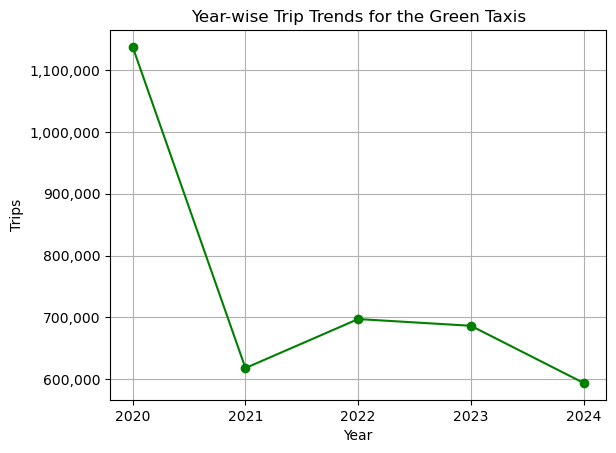

In [30]:
import matplotlib.ticker as ticker

plt.figure()
plt.plot(green_df['year'], green_df['count'], marker="o", color="green")
plt.grid()
plt.xlabel('Year')
plt.ylabel('Trips')

# Force full numbers on Y-axis
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.title('Year-wise Trip Trends for the Green Taxis')
plt.xticks(green_df['year'])
plt.show()

In [60]:
yellow_year = (yellow.withColumn("year", F.year(F.col("tpep_pickup_datetime")))
              .groupBy("year")
              .count()
              .orderBy("year"))
yellow_df= yellow_year.toPandas()
yellow_df['year']= yellow_df['year'].astype(int)

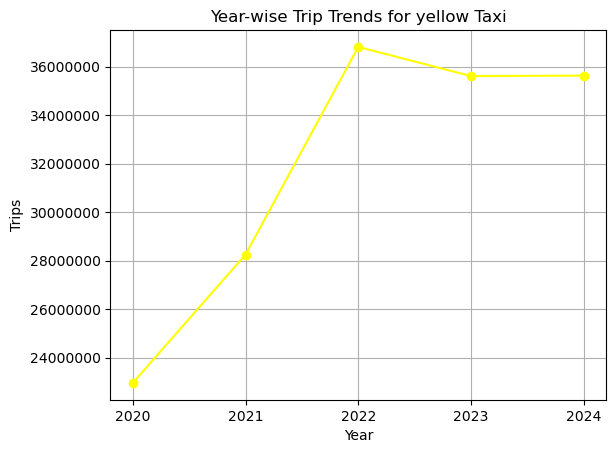

In [61]:
plt.figure()
plt.plot(yellow_df['year'], yellow_df['count'],marker= "o", color = "yellow")
plt.grid()
plt.xlabel('Year')
plt.ylabel('Trips')
plt.title('Year-wise Trip Trends for yellow Taxi')
plt.xticks(yellow_df['year'])

plt.ticklabel_format(style='plain', axis='y')
plt.show()

Hourly trip distribution separately for yellow and green taxis

In [49]:
green_hour_distribution = (green.withColumn("hour", F.hour(F.col("lpep_pickup_datetime")))
                            .groupBy("hour")
                            .count()
                            .orderBy("hour"))
green_hour_df = green_hour_distribution.toPandas()

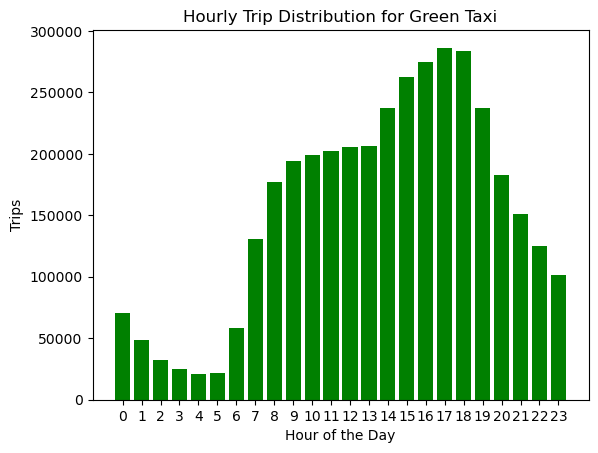

In [50]:
plt.figure()
plt.bar(green_hour_df['hour'], green_hour_df['count'], color = "green")
plt.xlabel('Hour of the Day')
plt.ylabel('Trips')
plt.title('Hourly Trip Distribution for Green Taxi')
plt.xticks(range(0,24))
plt.show()

In [11]:
yellow_hour_distribution = (yellow.withColumn("hour", F.hour(F.col("tpep_pickup_datetime")))
                            .groupBy("hour")
                            .count()
                            .orderBy("hour"))
yellow_hour_df = yellow_hour_distribution.toPandas()

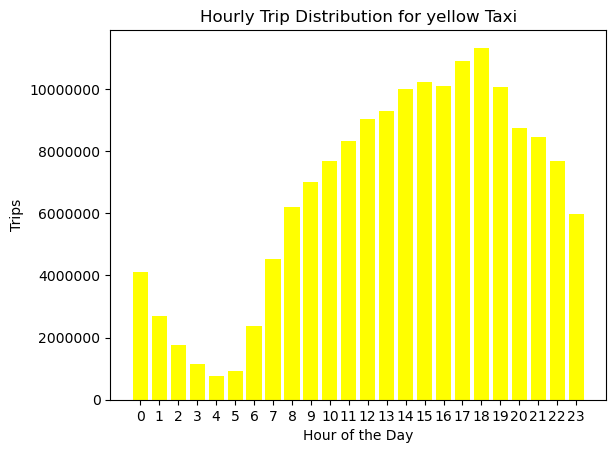

In [12]:
plt.figure()
plt.bar(yellow_hour_df['hour'], yellow_hour_df['count'], color = "yellow")
plt.xlabel('Hour of the Day')
plt.ylabel('Trips')
plt.title('Hourly Trip Distribution for yellow Taxi')
plt.xticks(range(0,24))
plt.ticklabel_format(style='plain', axis='y')
plt.show()

Histogram of fare amounts separately for Yellow and Green

In [11]:
green_mandatory_charges = green.withColumn("mandatory_total",
                                            F.col("fare_amount"))

green_fair_df = green_mandatory_charges.select("mandatory_total").toPandas()

/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:6890: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


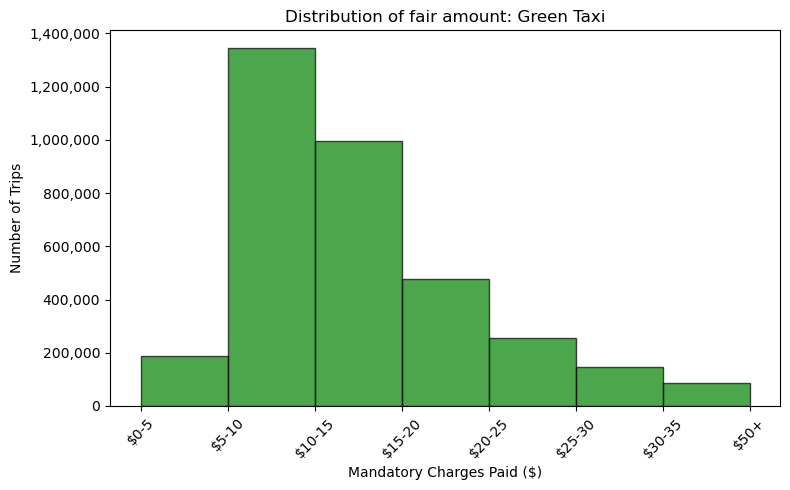

In [19]:
bins = np.arange(0, 40, 5)
bins = np.append(bins, [np.inf])
labels = [f'${int(bins[i])}-{int(bins[i+1])}' if not np.isinf(bins[i+1]) else '$50+' for i in range(len(bins)-1)]

plt.figure(figsize=(8, 5))
plt.hist(green_fair_df['mandatory_total'], bins=bins, color='green', alpha=0.7, edgecolor='black')
plt.xlabel('Mandatory Charges Paid ($)')
plt.ylabel('Number of Trips')
plt.title('Distribution of fair amount: Green Taxi')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.xticks(bins[:-1], labels, rotation=45)
plt.tight_layout()
plt.show()

In [17]:
yellow_mandatory_charges = yellow.withColumn("mandatory_total",
                                               F.col("fare_amount"))
yellow_fair_df = yellow_mandatory_charges.select("mandatory_total").toPandas()

/opt/conda/lib/python3.11/site-packages/matplotlib/axes/_axes.py:6890: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


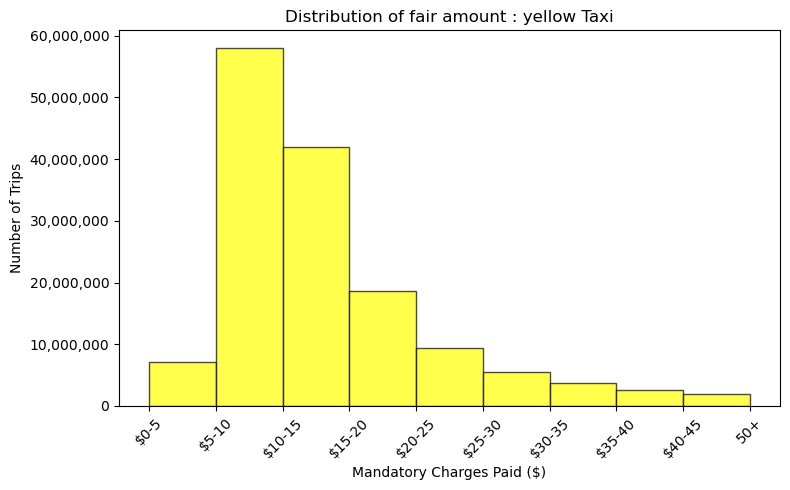

In [18]:
bins = np.arange(0, 50, 5)
bins = np.append(bins, [np.inf])
labels = [f'${int(bins[i])}-{int(bins[i+1])}' if not np.isinf(bins[i+1]) else '50+' for i in range(len(bins)-1)]

plt.figure(figsize=(8, 5))
plt.hist(yellow_fair_df['mandatory_total'], bins=bins, color='yellow', alpha=0.7, edgecolor='black')
plt.xlabel('Mandatory Charges Paid ($)')
plt.ylabel('Number of Trips')
plt.title('Distribution of fair amount : yellow Taxi')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.xticks(bins[:-1], labels, rotation=45)
plt.tight_layout()
plt.show()

Bar chart: most used payment methods 

In [24]:
green.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- lpep_pickup_datetime: timestamp (nullable = true)
 |-- lpep_dropoff_datetime: timestamp (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: double (nullable = true)
 |-- trip_type: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- year: integer (nullable = false)



In [ ]:
green_payment_distribution = (green.withColumn("payment_type", F.col("payment_type").cast("int")).groupBy("payment_type").count().orderBy("payment_type"))
green_payment_distribution_df  = green_payment_distribution.toPandas()



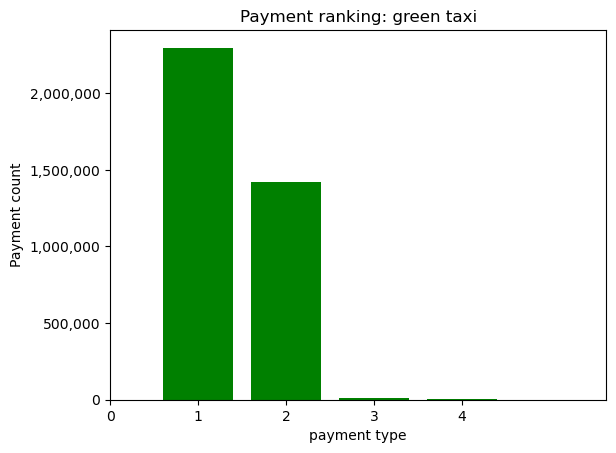

In [37]:
plt.figure()
plt.bar(green_payment_distribution_df['payment_type'], green_payment_distribution_df['count'], color = "green")
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.xlabel('payment type')
plt.ylabel('Payment count')
plt.title('Payment ranking: green taxi')
plt.xticks(range(0,5))
plt.show()

yellow

In [30]:
yellow_payment_distribution = (yellow.withColumn("payment_type", F.col("payment_type").cast("int")).groupBy("payment_type").count().orderBy("payment_type"))
yellow_payment_distribution_df = yellow_payment_distribution.toPandas()

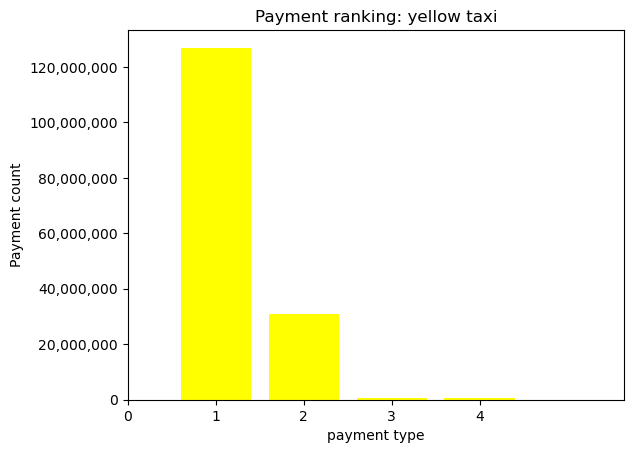

In [36]:

plt.figure()
plt.bar(yellow_payment_distribution_df['payment_type'], yellow_payment_distribution_df['count'], color = "yellow")
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.xlabel('payment type')
plt.ylabel('Payment count')
plt.title('Payment ranking: yellow taxi')
plt.xticks(range(0,5))
plt.show()

# Ml lib

## Green

In [22]:
numeric = [
    "passenger_count",
    "trip_distance",
    "fare_amount",
    "extra",
    "mta_tax",
    "tip_amount",
    "tolls_amount",
    "improvement_surcharge",
    "total_amount"
]

Data info

In [ ]:
#checking the statistics of the green taxi data
agg_exprs = []
for c in numeric:
    agg_exprs.extend([
        F.min(F.col(c)).alias(f"{c}_min"),
        F.max(F.col(c)).alias(f"{c}_max"),
        F.mean(F.col(c)).alias(f"{c}_mean"),
        F.stddev(F.col(c)).alias(f"{c}_stddev"),
        F.sum(F.col(c)).alias(f"{c}_sum"),
    ])
green.agg(*agg_exprs).show()


+-------------------+-------------------+--------------------+----------------------+-------------------+-----------------+-----------------+------------------+--------------------+--------------------+---------------+---------------+-----------------+------------------+--------------------+---------+---------+------------------+-----------------+----------+-----------+-----------+------------------+-------------------+-----------+--------------+--------------+------------------+-----------------+-----------------+----------------+----------------+------------------+-------------------+-----------------+-------------------------+-------------------------+--------------------------+----------------------------+-------------------------+----------------+----------------+------------------+-------------------+-------------------+
|passenger_count_min|passenger_count_max|passenger_count_mean|passenger_count_stddev|passenger_count_sum|trip_distance_min|trip_distance_max|trip_distance_mean|t

Outliers

In [ ]:
#outliers in the numeric columns
numeric_outliers = [
    "trip_distance",
    "fare_amount",
    "extra",
    "mta_tax",
    "tip_amount",
    "tolls_amount",
    "improvement_surcharge",
    "total_amount"
]

In [ ]:
#removing the outliers from the green taxi data
for col in numeric_outliers:

    q1, q3 = green.approxQuantile(col, [0.25, 0.75], 0.01)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    green = green.filter((F.col(col) >= lower) & (F.col(col) <= upper))
print(f"Number of rows after removing outliers:{green.count()}")

Number of rows after removing outliers:2916990


In [132]:
agg_exprs = []
for c in numeric:
    agg_exprs.extend([
        F.min(F.col(c)).alias(f"{c}_min"),
        F.max(F.col(c)).alias(f"{c}_max"),
        F.mean(F.col(c)).alias(f"{c}_mean"),
        F.stddev(F.col(c)).alias(f"{c}_stddev"),
        F.sum(F.col(c)).alias(f"{c}_sum"),
    ])
green.agg(*agg_exprs).show()

+-------------------+-------------------+--------------------+----------------------+-------------------+-----------------+-----------------+------------------+--------------------+-----------------+---------------+---------------+------------------+------------------+--------------------+---------+---------+------------------+------------------+---------+-----------+-----------+------------+--------------+-----------+--------------+--------------+---------------+-----------------+-----------------+----------------+----------------+-----------------+-------------------+----------------+-------------------------+-------------------------+--------------------------+----------------------------+-------------------------+----------------+----------------+------------------+-------------------+--------------------+
|passenger_count_min|passenger_count_max|passenger_count_mean|passenger_count_stddev|passenger_count_sum|trip_distance_min|trip_distance_max|trip_distance_mean|trip_distance_stdd

In [41]:
green.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- lpep_pickup_datetime: timestamp (nullable = true)
 |-- lpep_dropoff_datetime: timestamp (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: double (nullable = true)
 |-- trip_type: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- year: integer (nullable = false)



In [ ]:
#selecting the columns we need and generating new features
green_data = green.select([
    "VendorID", "lpep_pickup_datetime", "lpep_dropoff_datetime", 
    "store_and_fwd_flag", "RatecodeID", "PULocationID", "DOLocationID",
    "passenger_count", "trip_distance", "fare_amount", "extra", "mta_tax",
    "tip_amount", "tolls_amount", "improvement_surcharge", "total_amount",
    "payment_type", "trip_type", "congestion_surcharge", "year"
])

green_data = green_data.withColumn("weekday", F.dayofweek(F.col("lpep_pickup_datetime")))
green_data = green_data.withColumn("hour", F.hour(F.col("lpep_pickup_datetime")))

green_data = green_data.withColumn(
    "duration_trip",
    (F.unix_timestamp(F.col("lpep_dropoff_datetime")) - F.unix_timestamp(F.col("lpep_pickup_datetime"))) / 60.0
)

green_data = green_data.withColumn(
    "trip_in_hour",
    (F.col("duration_trip") / 60.0).cast("float")
)

green_data = green_data.withColumn(
    "distance_p_minute",
    (F.col("trip_distance") / F.col("duration_trip")).cast("float")
)

green_data = green_data.withColumn(
    "distance_p_passenger",
    (F.col("trip_distance") / F.col("passenger_count")).cast("float")
)

green_data = green_data.withColumn(
    "part_of_day",
    F.when((F.col("hour") >= 6) & (F.col("hour") < 12), "morning")
     .when((F.col("hour") >= 12) & (F.col("hour") < 18), "afternoon")
     .otherwise("evening")
)

green_data = green_data.withColumn(
    "part_of_week",
    F.when(F.col("weekday").isin([1, 7]), "weekend")
     .otherwise("weekday")
)

green_data = green_data.dropna()

In [85]:
green_data.show(5)

+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------------------+------------+------------+---------+--------------------+----+-------+----+------------------+------------+-----------------+--------------------+-----------+------------+
|VendorID|lpep_pickup_datetime|lpep_dropoff_datetime|store_and_fwd_flag|RatecodeID|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|payment_type|trip_type|congestion_surcharge|year|weekday|hour|     duration_trip|trip_in_hour|distance_p_minute|distance_p_passenger|part_of_day|part_of_week|
+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------------------+------------+----------

In [ ]:
#indexing the part of day and part of week
part_of_day_indexer = StringIndexer(inputCol="part_of_day", outputCol="part_of_day_idx")
green_data = part_of_day_indexer.fit(green_data).transform(green_data)


part_of_week_indexer = StringIndexer(inputCol="part_of_week", outputCol="part_of_week_idx")
green_data = part_of_week_indexer.fit(green_data).transform(green_data)

In [87]:
green_data.show()

+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------------------+------------+------------+---------+--------------------+----+-------+----+------------------+------------+-----------------+--------------------+-----------+------------+---------------+----------------+
|VendorID|lpep_pickup_datetime|lpep_dropoff_datetime|store_and_fwd_flag|RatecodeID|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|payment_type|trip_type|congestion_surcharge|year|weekday|hour|     duration_trip|trip_in_hour|distance_p_minute|distance_p_passenger|part_of_day|part_of_week|part_of_day_idx|part_of_week_idx|
+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+---

In [ ]:
#vectorising the features
assembler = VectorAssembler(inputCols=["trip_distance",
                                       "improvement_surcharge",
                                       "distance_p_minute",
                                       "duration_trip"],
                            outputCol="features")
green_data = assembler.transform(green_data)

In [ ]:
#selecting the features and the label
green_final = green_data.select("features", "fare_amount")
green_final= green_final.withColumnRenamed("fare_amount","label")

In [29]:
train_data, test_data = green_final.randomSplit([0.8, 0.2], seed=42)

In [30]:
lr = LinearRegression(regParam=0.0, solver="normal", maxIter=5,standardization=False)
rf = RandomForestRegressor(numTrees= 10, maxDepth= 5, seed=42)
gbt = GBTRegressor(maxDepth=7, seed=42, maxIter=5)



null_counts = green.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in green.columns])
null_counts.show()

In [31]:
rmse_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
mae_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
r2_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

In [32]:
print("Linear Regression")
lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)
print("RMSE")
# RMSE
g_lr_rmse = rmse_evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {g_lr_rmse:.2f}")

# MAE
g_lr_mae = mae_evaluator.evaluate(predictions)
print(f"Mean Absolute Error (MAE): {g_lr_mae:.2f}")

# R2
g_lr_r2 = r2_evaluator.evaluate(predictions)
print(f"R^2: {g_lr_r2:.2f}")

Linear Regression
RMSE
Root Mean Squared Error (RMSE): 1.90
Mean Absolute Error (MAE): 1.33
R^2: 0.85


In [33]:
print("Random Forest Regressor")

model = rf.fit(train_data)

predictions = model.transform(test_data)

# RMSE
g_rf_rmse = rmse_evaluator.evaluate(predictions)
print("Test RMSE:", g_rf_rmse)
# MAE

g_rf_mae = mae_evaluator.evaluate(predictions)
print("MAE:", g_rf_mae)
# R2
g_rf_r2 = r2_evaluator.evaluate(predictions)
print("R2:", g_rf_r2)

Random Forest Regressor


Test RMSE: 1.0247487570040408
MAE: 0.6465033091023025
R2: 0.955256575419294


In [34]:
print("GBT regressor")

model = gbt.fit(train_data)
predictions = model.transform(test_data)

g_gbt_rmse = rmse_evaluator.evaluate(predictions)
print("Test RMSE:", g_gbt_rmse)

# MAE
g_gbt_mae = mae_evaluator.evaluate(predictions)
print("MAE:", g_gbt_mae)

# R²

g_gbt_r2 = r2_evaluator.evaluate(predictions)
print("R2:", g_gbt_r2)

GBT regressor
Test RMSE: 0.7548596785270419
MAE: 0.46397141080164805
R2: 0.9757212190776244


In [35]:
# Get feature importances
input_cols = assembler.getInputCols()
importance_list = model.featureImportances.toArray().tolist()
print("input_cols length:", len(input_cols))
print("importance_list length:", len(importance_list))


input_cols length: 4
importance_list length: 4


In [36]:
print("Most important features for green taxi data prediction")

fi_df = pd.DataFrame({
    'feature': input_cols,
    'importance': importance_list
})
fi_df = fi_df.sort_values('importance', ascending=False)
print(fi_df)

Most important features for green taxi data prediction
                 feature  importance
3          duration_trip    0.728589
0          trip_distance    0.180409
1  improvement_surcharge    0.085073
2      distance_p_minute    0.005928


## Yellow

In [47]:
yellow.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- year: integer (nullable = false)



In [ ]:
#numeric columns for yellow taxi data
yellow_numeric_outliers = [
    "trip_distance",
    "fare_amount",
    "extra",
    "mta_tax",
    "tip_amount",
    "tolls_amount",
    "improvement_surcharge",
    "total_amount"
]

In [ ]:
#checking the statistics of the yellow taxi data
agg_exprs = []
for c in yellow_numeric_outliers:
    agg_exprs.extend([
        F.min(F.col(c)).alias(f"{c}_min"),
        F.max(F.col(c)).alias(f"{c}_max"),
        F.mean(F.col(c)).alias(f"{c}_mean"),
        F.stddev(F.col(c)).alias(f"{c}_stddev"),
        F.sum(F.col(c)).alias(f"{c}_sum"),
    ])
yellow.agg(*agg_exprs).show()

+-----------------+-----------------+------------------+--------------------+-------------------+---------------+---------------+-----------------+------------------+-------------------+---------+---------+------------------+------------------+--------------------+-----------+-----------+------------------+------------------+-------------------+--------------+--------------+------------------+------------------+--------------------+----------------+----------------+------------------+-------------------+-------------------+-------------------------+-------------------------+--------------------------+----------------------------+-------------------------+----------------+----------------+------------------+-------------------+-------------------+
|trip_distance_min|trip_distance_max|trip_distance_mean|trip_distance_stddev|  trip_distance_sum|fare_amount_min|fare_amount_max| fare_amount_mean|fare_amount_stddev|    fare_amount_sum|extra_min|extra_max|        extra_mean|      extra_stddev

In [ ]:
#removing the outliers from the yellow taxi data
for col in yellow_numeric_outliers:
    # Compute Q1 and Q3
    q1, q3 = yellow.approxQuantile(col, [0.25, 0.75], 0.01)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    # Filter DataFrame for this column's outliers
    yellow = yellow.filter((F.col(col) >= lower) & (F.col(col) <= upper))


In [ ]:
#selecting relevant columns and creating new features
yellow_data = yellow.select(
    "tpep_pickup_datetime", "tpep_dropoff_datetime", "passenger_count",
    "trip_distance", "fare_amount", "mta_tax", "tip_amount", 
    "improvement_surcharge", "congestion_surcharge","RatecodeID",
).withColumn("hour", F.hour(F.col("tpep_pickup_datetime"))) \
 .withColumn("duration_trip", 
    (F.unix_timestamp(F.col("tpep_dropoff_datetime")) - F.unix_timestamp(F.col("tpep_pickup_datetime"))) / 60.0) \
 .withColumn("weekday", F.dayofweek(F.col("tpep_pickup_datetime"))) \
 .withColumn("part_of_day",
    F.when((F.col("hour") >= 6) & (F.col("hour") < 12), "morning")
     .when((F.col("hour") >= 12) & (F.col("hour") < 18), "afternoon")
     .otherwise("evening")) \
 .withColumn("part_of_week",
    F.when(F.col("weekday").isin([1, 7]), "weekend")
     .otherwise("weekday")) \
 .withColumn("distance_p_passenger", 
    F.col("trip_distance") / F.col("passenger_count")) \
 .withColumn("Distance_p_hour", 
    F.col("trip_distance") / F.col("duration_trip"))

In [ ]:
#dropping the na values that occured after feature engineering
yellow_data=yellow_data.dropna()

In [ ]:
#vectorising the features
assembler = VectorAssembler(inputCols=[
    "duration_trip",
    "trip_distance",
    "improvement_surcharge",
    "Distance_p_hour"],
                            outputCol="features")
yellow_data = assembler.transform(yellow_data)

In [ ]:
#selecting the features and the label
ydata = yellow_data.select("features", "fare_amount")

In [ ]:
#renaming the fare_amount column to label
ydata= ydata.withColumnRenamed("fare_amount","label")

In [ ]:
#checking the cache status
show_cache_status()

In [ ]:
#starting count operation to utilise caching the marked data
ydata.count()

131357731

In [ ]:

# splitting the data into train and test
train_data, test_data = ydata.randomSplit([0.8, 0.2], seed=42)

In [48]:
lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)

In [49]:
# RMSE
y_lr_rmse = rmse_evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {y_lr_rmse:.2f}")

# MAE
y_lr_mae = mae_evaluator.evaluate(predictions)
print(f"Mean Absolute Error (MAE): {y_lr_mae:.2f}")

# R2
y_lr_r2 = r2_evaluator.evaluate(predictions)
print(f"R^2: {y_lr_r2:.2f}")

Root Mean Squared Error (RMSE): 2.24
Mean Absolute Error (MAE): 1.61
R^2: 0.77


In [50]:
model = rf.fit(train_data)
predictions = model.transform(test_data)

In [51]:

# Evaluate (e.g., RMSE)
y_rf_rmse = rmse_evaluator.evaluate(predictions)
print("Test RMSE:", y_rf_rmse)

y_rf_mae = mae_evaluator.evaluate(predictions)
print("MAE:", y_rf_mae)


y_rf_r2 = r2_evaluator.evaluate(predictions)
print("R2:", y_rf_r2)

Test RMSE: 0.9242288491355892
MAE: 0.5708400855044825
R2: 0.9615518000381382


In [52]:
model = gbt.fit(train_data)
predictions = model.transform(test_data)



In [53]:

y_gbt_rmse = rmse_evaluator.evaluate(predictions)
print("Test RMSE:", y_gbt_rmse)

# MAE
y_gbt_mae = mae_evaluator.evaluate(predictions)
print("MAE:", y_gbt_mae)

# R²
y_gbt_r2 = r2_evaluator.evaluate(predictions)
print("R2:", y_gbt_r2)

Test RMSE: 0.7448207092776451
MAE: 0.4571654900360268
R2: 0.9750298898674624


In [54]:
feature_names = assembler.getInputCols()

In [55]:
input_cols = assembler.getInputCols()
importance_list = model.featureImportances.toArray().tolist()
print("input_cols length:", len(input_cols))
print("importance_list length:", len(importance_list))

input_cols length: 4
importance_list length: 4


In [56]:
fi_df = pd.DataFrame({
    'feature': input_cols,
    'importance': importance_list
})
fi_df = fi_df.sort_values('importance', ascending=False)
print(fi_df)

                 feature  importance
0          duration_trip    0.793724
1          trip_distance    0.123310
2  improvement_surcharge    0.072608
3        Distance_p_hour    0.010358


## Performance

In [58]:

performance_df = pd.DataFrame({
    'Dataset': ['Green', 'Green', 'Green', 'Yellow', 'Yellow', 'Yellow'],
    'Model': ['Linear Regression', 'Random Forest', 'GBT', 'Linear Regression', 'Random Forest', 'GBT'],
    'RMSE': [g_lr_rmse, g_rf_rmse, g_gbt_rmse, y_lr_rmse, y_rf_rmse, y_gbt_rmse],
    'MAE': [g_lr_mae, g_rf_mae, g_gbt_mae, y_lr_mae, y_rf_mae, y_gbt_mae],
    'R²': [g_lr_r2, g_rf_r2, g_gbt_r2, y_lr_r2, y_rf_r2, y_gbt_r2],
})

In [59]:
performance_df.head(6)

,Dataset,Model,RMSE,MAE,R²
0,Green,Linear Regression,1.900678,1.330474,0.846074
1,Green,Random Forest,1.024749,0.646503,0.955257
2,Green,GBT,0.754860,0.463971,0.975721
3,Yellow,Linear Regression,2.236599,1.610875,0.774839
4,Yellow,Random Forest,0.924229,0.570840,0.961552
5,Yellow,GBT,0.744821,0.457165,0.975030


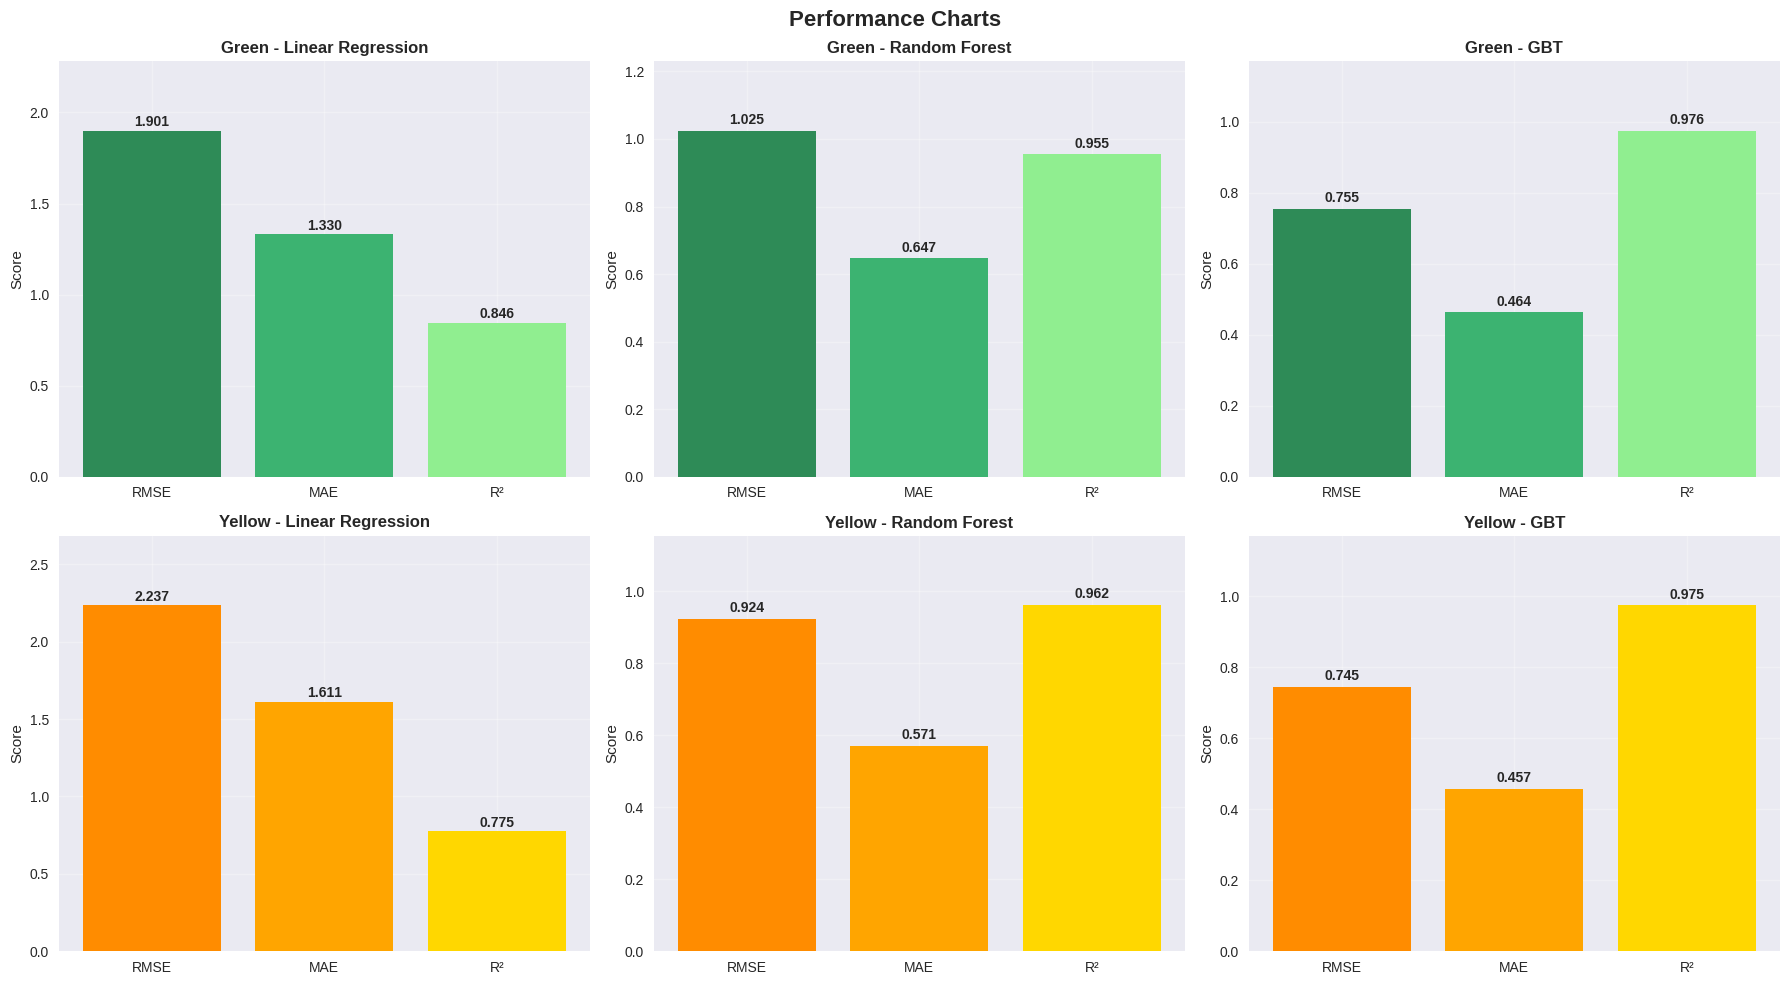

In [ ]:

#style
plt.style.use('seaborn-v0_8')

# individual bar charts for each row
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Performance Charts', fontsize=16, fontweight='bold')

# Flatten axes for easier iteration
axes = axes.flatten()

# Create a bar chart for each row
for i, (idx, row) in enumerate(performance_df.iterrows()):
    # Get the metrics for the row
    metrics = ['RMSE', 'MAE', 'R²']
    values = [row['RMSE'], row['MAE'], row['R²']]
    
    # Choose colors matched to relevant dataset 
    if row['Dataset'] == 'Green':
        colors = ['#2E8B57', '#3CB371', '#90EE90']  # Green shades
    else:  # Yellow dataset
        colors = ['#FF8C00', '#FFA500', '#FFD700']  # Yellow/Orange shades
    
    # Create bar chart
    bars = axes[i].bar(metrics, values, color=colors)
    
    # Set title for this subplot
    title = f"{row['Dataset']} - {row['Model']}"
    axes[i].set_title(title, fontweight='bold', fontsize=12)
    
    # Set y-axis label
    axes[i].set_ylabel('Score')
    
    # Add value labels on bars
    for j, (bar, value) in enumerate(zip(bars, values)):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                     f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Add grid
    axes[i].grid(True, alpha=0.3)
    
    # Set y-axis limits for better visualization
    axes[i].set_ylim(0, max(values) * 1.2)

plt.tight_layout()
plt.show()